# Relevant Imports

In [1]:
import math
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from confeddi import FederatedSystem
from distribute_data import generate_data
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Preprocess Data

### Load RTT Data

In [2]:
data = pd.read_csv('RTT_data.csv')

# Getting rid of complex-valued columns
data = data.select_dtypes(exclude = ['object'])

# Quick look at data
print(f'Number of samples: {data.shape[0]}')
print(f'Features per sample: {data.shape[1] - 1}\n')
print(f'Columns:')
for i in data.columns[:-1]:
    if i == 'GroundTruthRange[m]':
        continue
    print(f'{i}, ', end = '')
print(data.columns[-1], end = '')


# Separate data and labels
X = data.drop(columns = ['GroundTruthRange[m]']).to_numpy()
y = data['GroundTruthRange[m]'].to_numpy()

Number of samples: 29581
Features per sample: 10

Columns:
%Timestamp[s], GroundTruthPositionX[m], GroundTruthPositionY[m], GroundTruthPositionZ[m], ML_range_estimate[m], AP_positionX[m], AP_positionY[m], AP_positionZ[m], AP_index, ToD_factor[m]

### Distribute data among clients

In [3]:
seed = 11

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = seed)

data = generate_data(X_train, y_train, seed = seed)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X = scaler.fit_transform(X)


In [4]:
tf.keras.utils.set_random_seed(50)
tf.config.experimental.enable_op_determinism()

rounds = 50
a_search = np.logspace(-2, 3, 6)
l_search = np.logspace(-3, 1, 5)
history = dict()
Mt = (np.ones(rounds) * 5).astype('int32')
count = 1
for i, a in enumerate(a_search):
    for j, l in enumerate(l_search):
        print(f'Training Model {count}')
        fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
        fed.SetValData({'Val Data': X_val, 'Val Labels': y_val})
        fed.SetTestData({'Data': X, 'Labels': y})
        w, b = fed.ConFeddi(a, l, rounds = rounds, Mt = Mt)
        history[(a, l)] = (fed.test_loss(), fed.GetLog())
        count += 1
        print()


Training Model 1
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 2
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 3
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 4
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 5
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 6
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 7
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 8
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 9
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 10
Round 5
Round 10
Ro

In [5]:
fedavg_test_mse = np.load('history/important baselines/fedavg_test_mse.npy')
fedavg_log = np.load('history/important baselines/fedavg_log.npy')

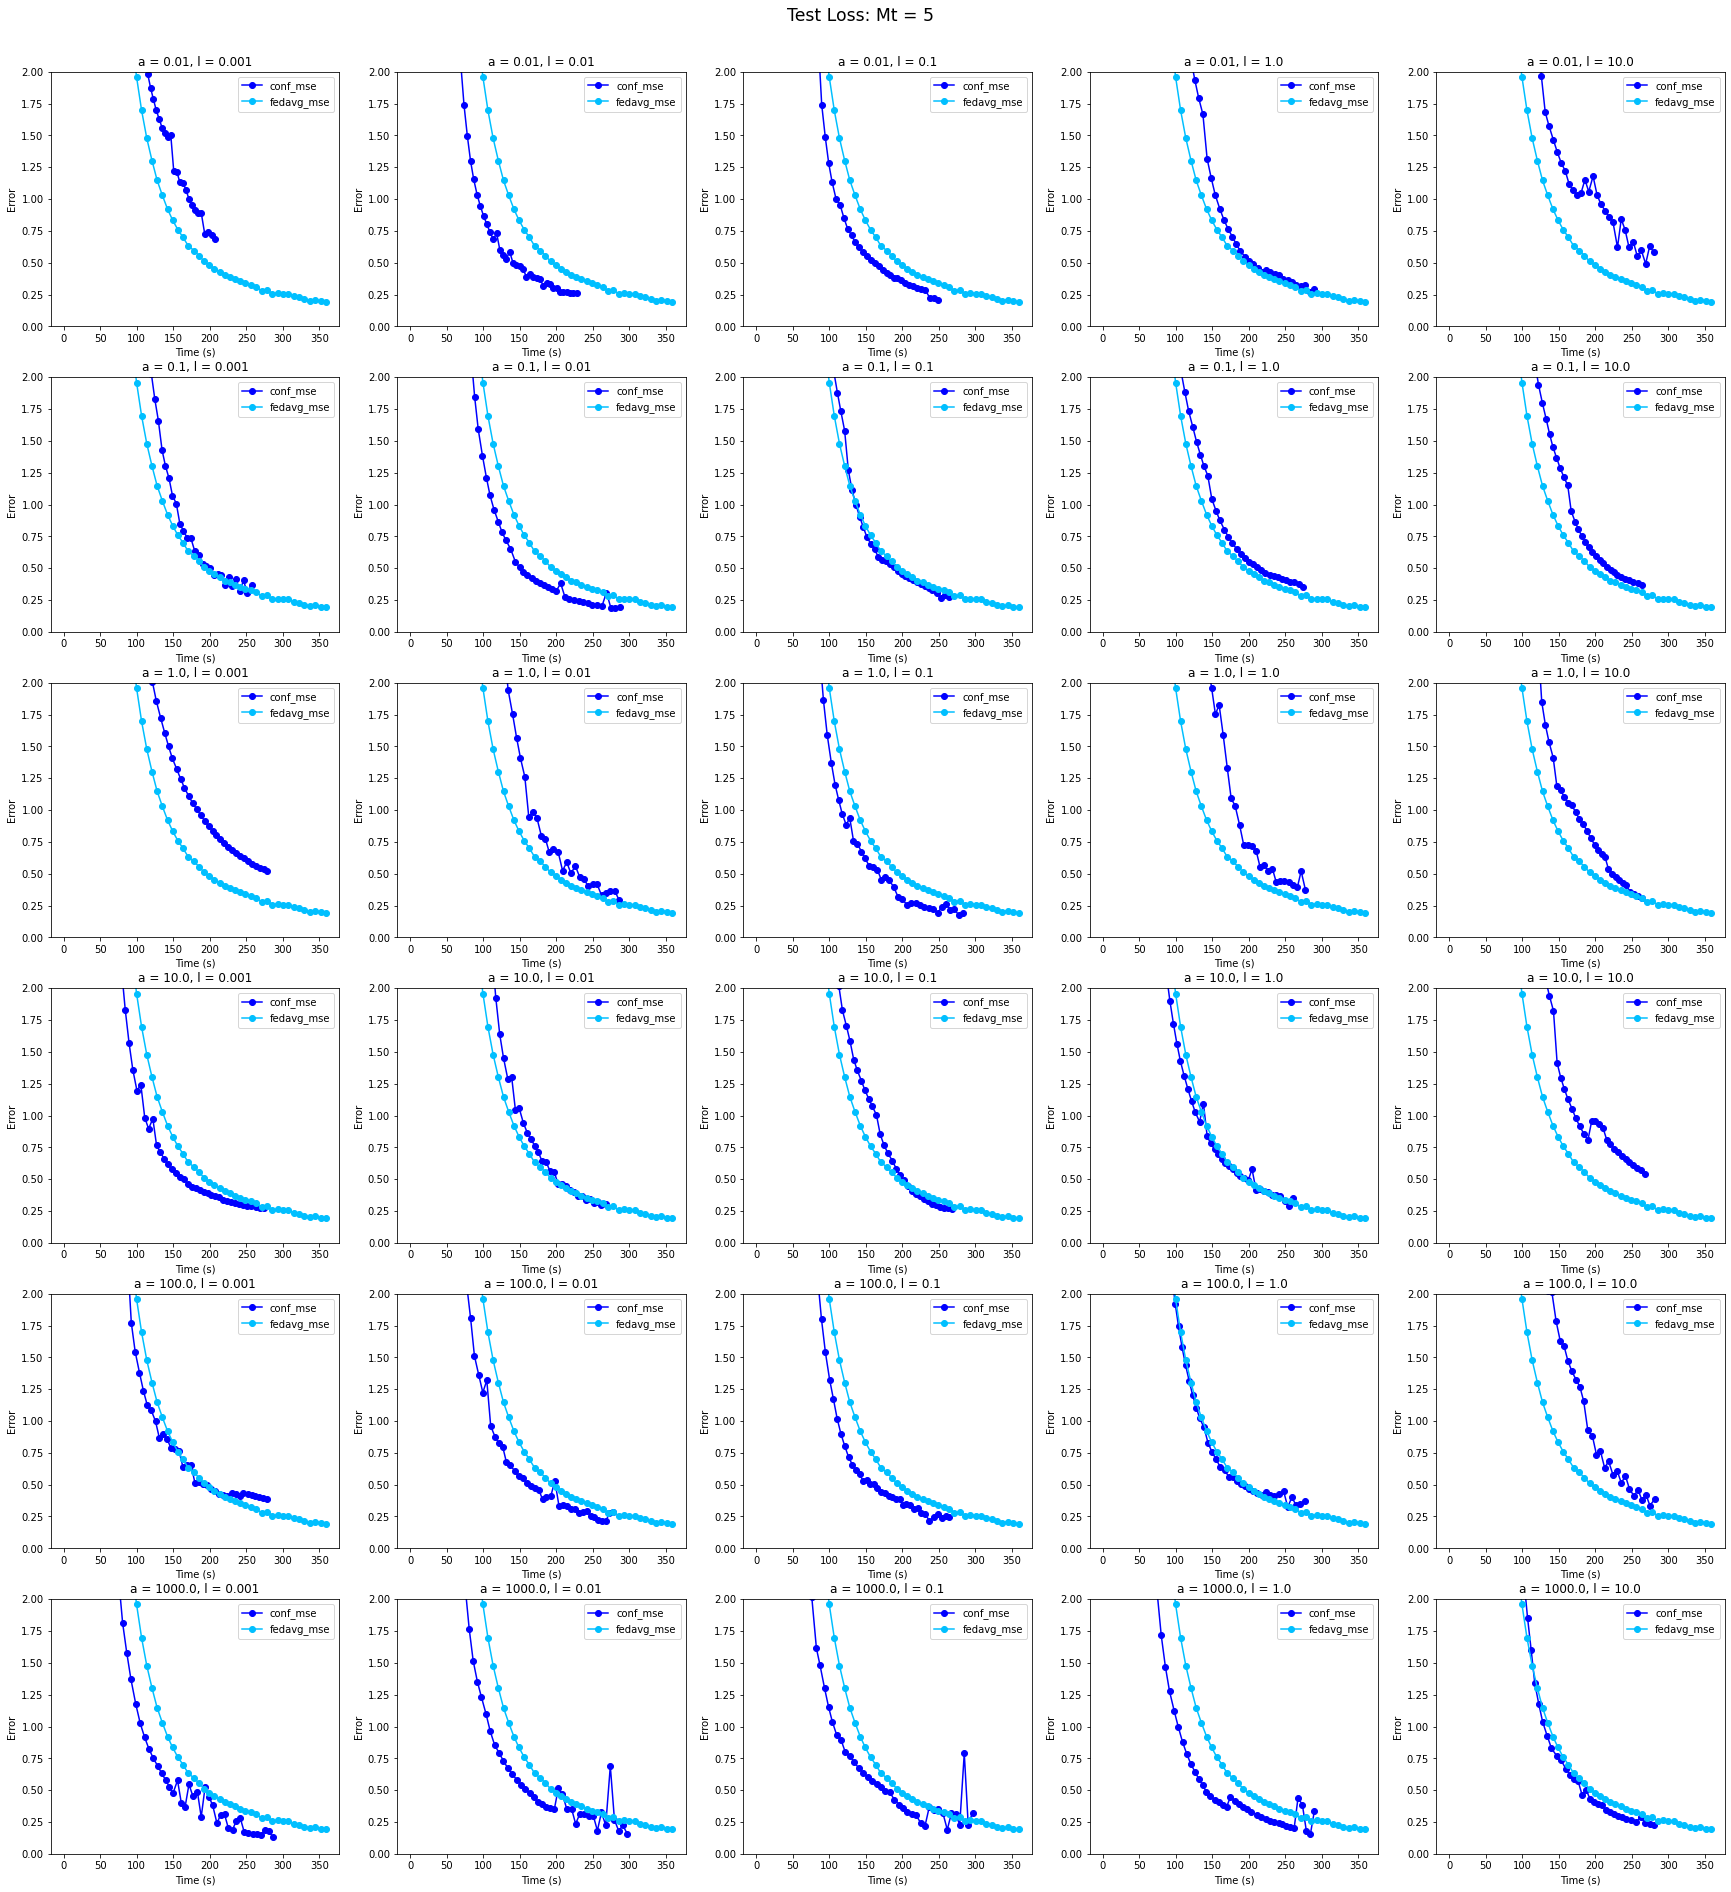

In [6]:
r, c, = 6, 5
fig = plt.figure(figsize = (30, 30))
plt.suptitle('Test Loss: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)

plot = 1
for run in history.items():
    a, l = run[0]
    err,  time=  run[1]
    fig.add_subplot(r, c, plot)
    plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
    plt.plot(fedavg_log, fedavg_test_mse, color = 'deepskyblue', label = 'fedavg_mse', marker = 'o')
    plt.title(f'a = {a}, l = {l}')
    plt.ylim(0, 2)
    plt.ylabel('Error')
    plt.xlabel('Time (s)')
    plt.legend()

    #print(f'a = {a}, l = {l}, Final mse: {err[-1]}')

    plot += 1


    

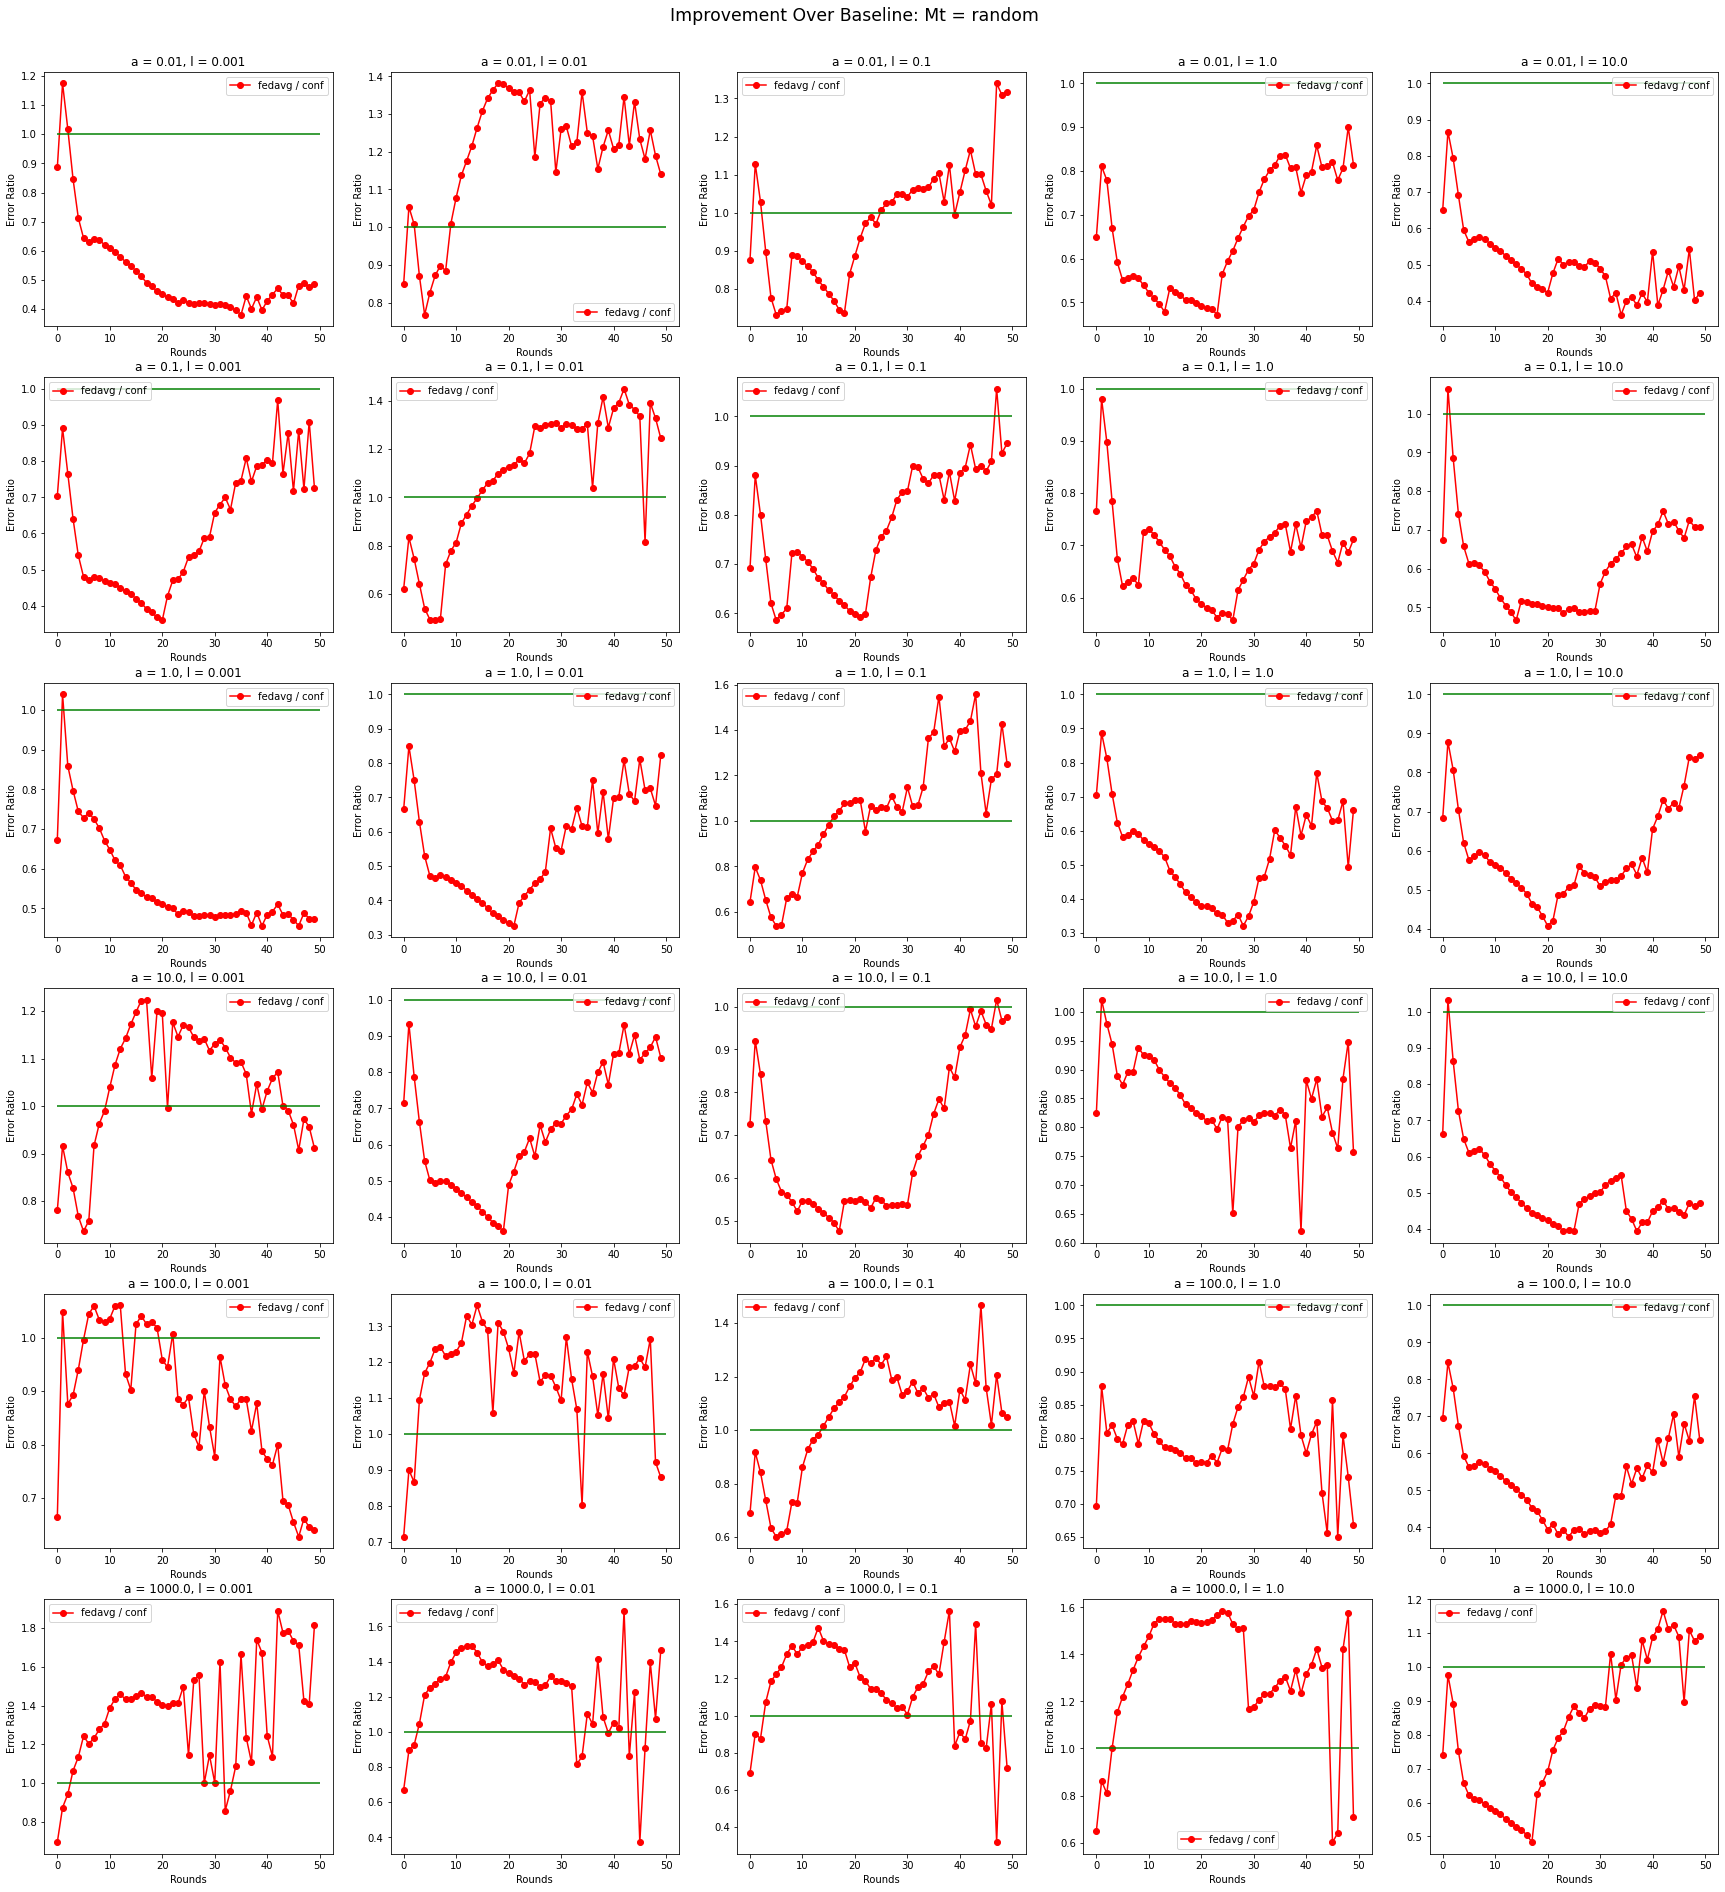

In [8]:
r, c, = 6, 5
fig = plt.figure(figsize = (30, 30))
plt.suptitle('Improvement Over Baseline: Mt = random', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)

plot = 1
for run in history.items():
    a, l = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)
    plt.plot((fedavg_log[1:] / time[1:]) * (np.array(fedavg_test_mse[1:]) / np.array(err[1:])), color = 'red', label = 'fedavg / conf', marker = 'o')
    plt.title(f'a = {a}, l = {l}')
    plt.ylabel('Error Ratio')
    plt.xlabel('Rounds')
    plt.hlines(1, 0, 50, color = 'green')
    plt.legend()

    plot += 1